# Construção do indicador - Taxa de desemprego por tipo

Jupyter Notebook para analisar os dados da Pesquisa de Emprego e Desemprego conforme estão em `raw/DIEPS/bases/ped-parquet/NovaPEDDF2018.parquet`.

## Leitura do MinIO

Leitura de todos os arquivos carregados do MinIO.

In [ ]:
import pyarrow.dataset as pds
import pyarrow.parquet as pq
import pyarrow as pa
import s3fs
import pandas as pd

In [ ]:
ACCESS_KEY = ''
SECRET_KEY = ''
MINIO_HOST = 'http://minio:9000'

In [ ]:
minio = s3fs.S3FileSystem(key=ACCESS_KEY, # change default key 
                        secret=SECRET_KEY, # change default secret
                        use_ssl=False,
                        client_kwargs={
                            'endpoint_url': MINIO_HOST} # change ip
                        )

# Verifiacação da conexão 
objects = minio.head('raw/DIEPS/bases/nova-ped-parquet')
objects

## Carregamento em dataframe

Os arquivos parquet listados acima serão carregados em um único dataframe.

In [373]:
from io import BytesIO
fs = s3fs.core.S3FileSystem()

part = pds.partitioning(
    pa.schema([
        ('year', pa.int16())
    ])
)
dataset = pq.ParquetDataset(
    'raw/DIEPS/bases/nova-ped-parquet',
    filesystem=minio,
    partitioning=part
)


# dt = dataset.to_table()
# dt
dataset.files

['raw/DIEPS/bases/nova-ped-parquet/2021/PED-DF_2021.parquet',
 'raw/DIEPS/bases/nova-ped-parquet/2022/PED-DF_2022.parquet',
 'raw/DIEPS/bases/nova-ped-parquet/2023/PED-DF_2023.parquet',
 'raw/DIEPS/bases/nova-ped-parquet/2024/PED-DF_2024.parquet']

In [374]:
fields = []
for field in dataset.schema:
    fields.append(field.name)
#del fields[83]
fields

['ANO_MES',
 'conglom',
 'NUM_DOMICILIO',
 'NUM_FAMILIA',
 'NUM_INDIVIDUO',
 'C000',
 'C030',
 'C040',
 'C050',
 'C061',
 'C062',
 'C070',
 'D010',
 'D0211',
 'D0212',
 'D0221',
 'D0222',
 'D0231',
 'D0232',
 'D0241',
 'D0242',
 'D0251',
 'D0252',
 'E000',
 'M011',
 'M012',
 'M021',
 'M022',
 'M031',
 'M032',
 'M041',
 'M042',
 'M051',
 'M052',
 'E010',
 'E020',
 'E030',
 'E040',
 'E050',
 'E060',
 'E070',
 'E080',
 'E090',
 'F010',
 'F020',
 'F030',
 'F040',
 'F050',
 'F061',
 'F062',
 'F063',
 'F070',
 'F080',
 'F090',
 'F100',
 'F111',
 'F112',
 'F113',
 'F120',
 'F130',
 'F141',
 'F142',
 'F143',
 'F150',
 'F160',
 'F170',
 'F180',
 'F190',
 'F201',
 'F202',
 'F210',
 'F220',
 'F230',
 'F240',
 'F250',
 'F260',
 'F270',
 'F280',
 'F290',
 'F300',
 'F310',
 'F320',
 'F330',
 'F340',
 'F350',
 'F360',
 'F370',
 'F380',
 'F390',
 'F400',
 'F410',
 'F420',
 'F430',
 'F440',
 'F451',
 'F452',
 'F453',
 'F461',
 'F462',
 'F463',
 'F470',
 'F481',
 'F482',
 'F483',
 'F484',
 'F485',
 'F49

In [375]:
# # Converte para pandas
fields_final = fields[0:82] + fields[83:]
df = dataset.read().to_pandas()

# df[['ANO_MES', 'fator2', 'C030', 'F010', 'F030', 'F070']].head(20)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261425 entries, 0 to 261424
Columns: 175 entries, ANO_MES to year
dtypes: category(168), float64(6), int16(1)
memory usage: 58.7 MB


# Plano amostral

Nessa seção é definido o plano amostral a partir dos dados da PED. Esse plano é aqui definido em conformidade com o código original em R, que segue abaixo:

```R
design <- svydesign(id = ~1, weights = ~FATOR2, data = PED)
```

Essa linha utiliza a coluna `FATOR2` como coluna de peso, e utiliza os dados no dataframe `PED`. O código `~1` indica que o peso é igual a 1 para todos os registros. 

In [436]:
df_sampled = df.sample(weights='fator2', frac=0.9)
df_sampled

,ANO_MES,conglom,NUM_DOMICILIO,NUM_FAMILIA,NUM_INDIVIDUO,C000,C030,C040,C050,C061,...,F65162,F65171,F65172,GRUPO,fator2,sit,POS,CNAE,SETOR_CNAE,year
244989,202409.0,4.700002e+10,342820.0,1.0,2.0,Apenas um morador,Feminino,Parda,26,Cônjuge / companheiro de sexo diferente,...,Não se aplica,Não,Não se aplica,Média-Baixa Renda,739.275932,Inativo Puro,Não ocupado,Não ocupado,Não ocupado,2024
151376,202304.0,3.100000e+10,127460.0,1.0,2.0,Mais de um morador,Feminino,Parda,55,Cônjuge / companheiro de sexo diferente,...,Não se aplica,Não,Não se aplica,Média-Baixa Renda,727.066576,Inativo Puro,Não ocupado,Não ocupado,Não ocupado,2023
172698,202308.0,3.000004e+10,285360.0,1.0,1.0,Apenas um morador,Feminino,Branca,74,Responsável,...,Não se aplica,Não,Não se aplica,Média-Alta Renda,565.453228,Inativo Puro,Não ocupado,Não ocupado,Não ocupado,2023
180537,202309.0,3.700005e+10,335512.0,1.0,2.0,Mais de um morador,Feminino,Parda,24,Cônjuge / companheiro de sexo diferente,...,Não se aplica,Não,Não se aplica,Média-Baixa Renda,710.389439,Ocupado,Ass Priv C Cart,Atividades Administrativas e Serviços Compleme...,Serviços,2023
162808,202306.0,3.200003e+10,210300.0,1.0,5.0,Mais de um morador,Feminino,Parda,16,Filho(a),...,Não se aplica,Não,Não se aplica,Baixa Renda,334.626590,Inativo Puro,Não ocupado,Não ocupado,Não ocupado,2023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84745,202204.0,3.200001e+10,129460.0,1.0,2.0,Apenas um morador,Masculino,Parda,64,Filho(a),...,Não se aplica,Não,Não se aplica,Baixa Renda,288.548519,Inativo Puro,Não ocupado,Não ocupado,Não ocupado,2022
131267,202212.0,3.800001e+10,457210.0,1.0,2.0,Apenas um morador,Masculino,Parda,43,Filho(a),...,Não se aplica,Não,Não se aplica,Baixa Renda,302.876321,Inativo Puro,Não ocupado,Não ocupado,Não ocupado,2022
64224,202112.0,3.900001e+10,458810.0,1.0,1.0,Apenas um morador,Feminino,Parda,44,Responsável,...,Não se aplica,Não,Não se aplica,Alta Renda,718.018762,Ocupado,Ass Pub,"Administração Pública, Defesa e Seguridade Soc...",Serviços,2021
30951,202106.0,3.900001e+10,218080.0,1.0,3.0,Mais de um morador,Masculino,Branca,14,Filho(a),...,Não se aplica,Não,Não se aplica,Alta Renda,739.455253,Inativo Puro,Não ocupado,Não ocupado,Não ocupado,2021


# Construção dos dataframes de PEA e desemprego

Esses dataframes, e suas médias móveis, serão utilizados para o cálculo da taxa de desemprego.

In [437]:
df2 = df_sampled[['ANO_MES', 'fator2', 'sit', 'C030', 'F010', 'F030', 'F070']].copy()
df2

,ANO_MES,fator2,sit,C030,F010,F030,F070
244989,202409.0,739.275932,Inativo Puro,Feminino,Não,Não,Não
151376,202304.0,727.066576,Inativo Puro,Feminino,Não,Não,Não
172698,202308.0,565.453228,Inativo Puro,Feminino,Não,Não,Não
180537,202309.0,710.389439,Ocupado,Feminino,Não,Não,Sim
162808,202306.0,334.626590,Inativo Puro,Feminino,Não,Não,Não
...,...,...,...,...,...,...,...
84745,202204.0,288.548519,Inativo Puro,Masculino,Não,Não,Não
131267,202212.0,302.876321,Inativo Puro,Masculino,Não,Não,Não
64224,202112.0,718.018762,Ocupado,Feminino,Não,Não,Sim
30951,202106.0,739.455253,Inativo Puro,Masculino,Não,Não,Não


In [438]:
# desempregado = list(df2['sit'].cat)
# desempregado
# df2['sit'].cat.codes.unique()
# Print df2['sit'].cat.ategories and df2['sit'].cat.codes side by side
unique_codes = list(df2['sit'].cat.codes.unique())
unique_codes.sort()
unique_cats = list(df2['sit'].cat.categories.unique())
for i in range(len(unique_cats)):
    print(f"{unique_codes[i]} {unique_cats[i]}")


0 Indefinido
1 Desemprego Oculto pelo Trabalho Precário
2 Desemprego Aberto
3 Desemprego Oculto pelo Desalento
4 Ocupado
5 Inativo com Trabalho Excepcional
6 Inativo Puro
7 Não se aplica (menor de 14 anos)


In [439]:
# População economicamente ativa (PEA): Situaçoes 4,5,6
#pea = pd.DataFrame(df2[
#    (
#        (df2['sit'] != 'Inativo com Trabalho Excepcional') &
#        (df2['sit'] != 'Inativo Puro') &
#        (df2['sit'] != 'Indefinido') &
#        (df2['sit'] != 'Não se aplica (menor de 14 anos)')
#    ) &
#    (
#        (df2['F010'] == 'Sim') | # Procurou trabalho nos últimos 30 dias?
#        (df2['F030'] == 'Sim') | # Procurou trabalho nos últimos 12 meses?
#        (df2['F070'] != 'Não se aplica') # Fez trabalho nos últimos 7 dias?
#    )
#].groupby(['ANO_MES'])['F010'].count())

pea = pd.DataFrame(df2[
    (
        (df2['sit'] != 'Inativo com Trabalho Excepcional') &
        (df2['sit'] != 'Inativo Puro') &
        (df2['sit'] != 'Indefinido') &
        (df2['sit'] != 'Não se aplica (menor de 14 anos)')
    )
].groupby(['ANO_MES'])['F010'].count())

pea.reset_index(inplace=True)
pea

pea_mean = pea.rolling(window=3, on='ANO_MES').mean()
pea_mean

,ANO_MES,F010
0,202101.0,NaN
1,202102.0,NaN
2,202103.0,2589.666667
3,202104.0,2631.333333
4,202105.0,2641.000000
5,202106.0,2650.666667
6,202107.0,2654.000000
7,202108.0,2676.000000
8,202109.0,2688.333333
9,202110.0,2635.333333


In [440]:
df3 = pea.merge(pea_mean, on='ANO_MES', how='left')
df3.head(12)

,ANO_MES,F010_x,F010_y
0,202101.0,2590,NaN
1,202102.0,2546,NaN
2,202103.0,2633,2589.666667
3,202104.0,2715,2631.333333
4,202105.0,2575,2641.000000
5,202106.0,2662,2650.666667
6,202107.0,2725,2654.000000
7,202108.0,2641,2676.000000
8,202109.0,2699,2688.333333
9,202110.0,2566,2635.333333


In [441]:
# Desempregados: Situaçoes 1,2 e 3 
#pea_desempregados = pd.DataFrame(df2[
#    (
#        (df2['sit'] != 'Inativo com Trabalho Excepcional') &
#        (df2['sit'] != 'Inativo Puro') &
#        (df2['sit'] != 'Ocupado')
#    ) &
#    (
#        (df2['F010'] == 'Sim') |
#        (df2['F030'] == 'Sim') &
#        (df2['F070'] != 'Não se aplica')
#    )].groupby(['ANO_MES', 'sit'])['F010'].count())
pea_desempregados = pd.DataFrame(df2[
    (
        (df2['sit'] == 'Desemprego Oculto pelo Trabalho Precário') |
        (df2['sit'] == 'Desemprego Aberto') |
        (df2['sit'] == 'Desemprego Oculto pelo Desalento')
    )].groupby(['ANO_MES'])['F010'].count())

pea_desempregados.reset_index(inplace=True)
pea_desempregados

pea_desempregados_mean = pea_desempregados.rolling(window=3, on='ANO_MES').mean()
pea_desempregados_mean.tail(12)

,ANO_MES,F010
36,202401.0,409.333333
37,202402.0,415.333333
38,202403.0,404.000000
39,202404.0,402.666667
40,202405.0,390.666667
41,202406.0,406.000000
42,202407.0,405.333333
43,202408.0,419.333333
44,202409.0,408.666667
45,202410.0,412.666667


In [442]:
# Média móvel da PEA e desempregados por mês
df4 = pea_desempregados.merge(pea_desempregados_mean, on='ANO_MES', how='left')
df4.tail(12)


,ANO_MES,F010_x,F010_y
36,202401.0,418,409.333333
37,202402.0,418,415.333333
38,202403.0,376,404.000000
39,202404.0,414,402.666667
40,202405.0,382,390.666667
41,202406.0,422,406.000000
42,202407.0,412,405.333333
43,202408.0,424,419.333333
44,202409.0,390,408.666667
45,202410.0,424,412.666667


In [443]:
df4 = df4.merge(df3, on='ANO_MES')
df4
df4.rename(columns={
    'F010_x_x': 'Desempregados (Absoluto)',
    'F010_y_x': 'Desempregados (Media movel)',
    'F010_x_y': 'PEA (Absoluto)',
    'F010_y_y': 'PEA (Media movel)',
    'sit': 'Situação',
    'ANO_MES': 'Ano.Mes'
}, inplace=True)

df4.tail(12)
# df3 = df3.loc[(df3!=0).all(axis=1)]
# df3

,Ano.Mes,Desempregados (Absoluto),Desempregados (Media movel),PEA (Absoluto),PEA (Media movel)
36,202401.0,418,409.333333,2663,2561.333333
37,202402.0,418,415.333333,2604,2586.333333
38,202403.0,376,404.000000,2506,2591.000000
39,202404.0,414,402.666667,2574,2561.333333
40,202405.0,382,390.666667,2597,2559.000000
41,202406.0,422,406.000000,2582,2584.333333
42,202407.0,412,405.333333,2720,2633.000000
43,202408.0,424,419.333333,2584,2628.666667
44,202409.0,390,408.666667,2458,2587.333333
45,202410.0,424,412.666667,2756,2599.333333


In [444]:
# Coluna com a taxa de desemprego
df4['Taxa de Desemprego'] = round(df4['Desempregados (Media movel)'] / df4['PEA (Media movel)'], 5) * 100
df4.tail(12)

,Ano.Mes,Desempregados (Absoluto),Desempregados (Media movel),PEA (Absoluto),PEA (Media movel),Taxa de Desemprego
36,202401.0,418,409.333333,2663,2561.333333,15.981
37,202402.0,418,415.333333,2604,2586.333333,16.059
38,202403.0,376,404.000000,2506,2591.000000,15.592
39,202404.0,414,402.666667,2574,2561.333333,15.721
40,202405.0,382,390.666667,2597,2559.000000,15.266
41,202406.0,422,406.000000,2582,2584.333333,15.710
42,202407.0,412,405.333333,2720,2633.000000,15.394
43,202408.0,424,419.333333,2584,2628.666667,15.952
44,202409.0,390,408.666667,2458,2587.333333,15.795
45,202410.0,424,412.666667,2756,2599.333333,15.876


In [445]:
# # campos relevantes
# final_df = df4.pivot(index='Ano.Mes', columns= values='Taxa de Desemprego')
final_df = df4[['Ano.Mes', 'Taxa de Desemprego']].tail(12)
final_df

,Ano.Mes,Taxa de Desemprego
36,202401.0,15.981
37,202402.0,16.059
38,202403.0,15.592
39,202404.0,15.721
40,202405.0,15.266
41,202406.0,15.710
42,202407.0,15.394
43,202408.0,15.952
44,202409.0,15.795
45,202410.0,15.876


# Analise

Gráficos para análise e possível identificação de indicadores nos dados

Taxa de desemprego 

In [446]:
import matplotlib.pyplot as plt

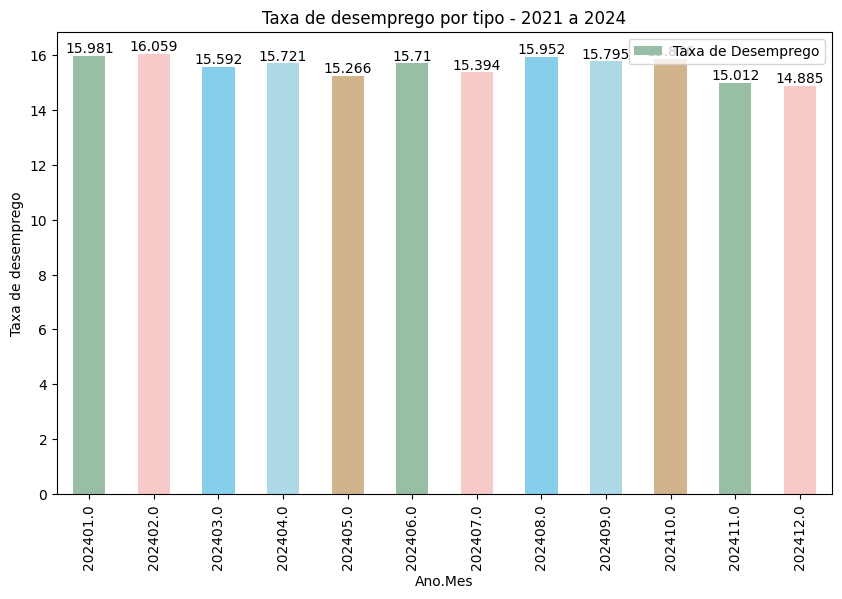

In [447]:

# Cores
pastel_colors = ['#98BFA5', '#F7CAC9', '#87CEEB', '#ADD8E6', '#D2B48C']


ax = final_df.plot(kind='bar', x='Ano.Mes', y='Taxa de Desemprego', stacked=False, color=pastel_colors, figsize=(10, 6))
ax.bar_label(ax.containers[-1])

# Apresenta o gráfico
plt.title('Taxa de desemprego por tipo - 2021 a 2024')
plt.ylabel('Taxa de desemprego')
plt.show()
